In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm
from collections import Counter

from gensim.models import Word2Vec
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans

import gensim.downloader as api

from sentence_transformers import SentenceTransformer
import torch

In [43]:
from IPython.display import display

# Permanently set options for the current session
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 50)
pd.set_option('display.width', 1000) 

In [44]:
# Path to your Parquet file
parquet_file_path = 'processed/processed_reviews.parquet'

# Read the Parquet file into a DataFrame
reviews_df = pd.read_parquet(parquet_file_path)

# Display the first few rows of the DataFrame
reviews_df.head()

,review_id,business_id,stars,categories,date,text,lemmas,num_lemmas,month,review_length,avg_word_length
0,mG1FavLfA5j2L83sCZ3rFg,drTZrkbpSoJgwKETlFbc3w,1.0,"Shopping, Musical Instrument Services, Musical...",2022-01-01 15:47:07,I bought a Fender 1966 Telecaster that the sal...,buy fender telecaster salesperson tell origina...,50,1,641,5.0
1,WMpnr1XBJ5U38rfSdErhJQ,jyxHti29yWdYR00Itt1A2w,5.0,"Restaurants, Mediterranean",2022-01-02 03:49:01,This is our go to for take out when I visit my...,visit son restaurant desert home food authenti...,14,1,208,4.0
2,99EMi0lRhdmylbG0soaf9w,Jo4ei-c-5H53IxZxAVf1jQ,5.0,"Hair Salons, Men's Hair Salons, Barbers, Beaut...",2022-01-03 03:17:03,Danielle did a great job! She listened and cu...,danielle great job listen cut hair way request...,24,1,278,4.0
3,Qs4z8e7hCoU9EzRKD9rGPQ,YT5CjacTllBtvMaMJS3IbA,1.0,"Hotels & Travel, Hotels, Venues & Event Spaces...",2022-01-05 15:55:59,We saw a lot of roaches in the bathroom when w...,see lot roach bathroom wake bed large dark sta...,38,1,514,4.0
4,SXZ2Nw9UGAgPlXJsju9fFA,9MHe5jAym2d8VhT_NbCRyw,2.0,"Restaurants, Chinese, Thai",2022-01-06 03:59:21,We Ordered pork fried rice and beef chow mei ...,order pork fry rice beef chow mei fun teriyaki...,16,1,148,5.0


### Embeddings
Word embeddings are representations that capture context and similarities in a vector space. Semantically similar words would have similar representations in that space. I will explore multiple embeddings models and compare semantic relationships uncovered by each.

#### i. Gensim Word2Vec (trained on our lemmas)
Each review has its own context window instead of a flat list of all lemmas. Uses local context(words around word) to predict word embedding.

Each input to the model must be a list of strings, in our case, lemmas(tokens). Therefore, we need to split out lemmas column, which is a space-separated string.

In [45]:
# Word2Vec expects a list of comma-separated tokens
reviews_df['lemma_tokens'] = reviews_df.lemmas.apply(lambda l: l.split())
reviews_df['lemma_tokens'].head()

0    [buy, fender, telecaster, salesperson, tell, o...
1    [visit, son, restaurant, desert, home, food, a...
2    [danielle, great, job, listen, cut, hair, way,...
3    [see, lot, roach, bathroom, wake, bed, large, ...
4    [order, pork, fry, rice, beef, chow, mei, fun,...
Name: lemma_tokens, dtype: object

In [46]:
model = Word2Vec(sentences=reviews_df.lemma_tokens, vector_size=200, window=5, min_count=5, workers=8)

In [47]:
words = model.wv.index_to_key
len(words)

10192

We can find similarity between two words in the vocabulary aka the cosine distance between their word vectors.

In [48]:
model.wv.similarity('tai', 'ziti')

0.82272756

Or find words in the vocabulary similar to a given word from the vocabulary.

In [49]:
# word similarity
model.wv.most_similar("saw", topn=10)

[('landscaping', 0.9525336027145386),
 ('repairman', 0.9469929337501526),
 ('bullshit', 0.9467512965202332),
 ('walker', 0.9459699392318726),
 ('generator', 0.945475161075592),
 ('nonsense', 0.94309401512146),
 ('faulty', 0.942777156829834),
 ('jefferson', 0.9417145252227783),
 ('steering', 0.9362192749977112),
 ('settlement', 0.9358218908309937)]

#### Visualize word embeddings
We can visualize clusters of similar words and observe words that are similar in context or semantically.

In [50]:
# From Stanford's notebook, https://web.stanford.edu/class/cs224n/materials/Gensim%20word%20vector%20visualization.html
pca = PCA(n_components=2, random_state=42)
def display_pca_scatterplot(model, sample=0):
    if sample > 0:
        words = np.random.choice(model.wv.index_to_key, sample)
    else:
        words = [word for word in model.wv.index_to_key]
        
    word_vectors = np.array(model.wv[words])

    twodim = pca.fit_transform(word_vectors)
    
    plt.figure(figsize=(10,8))
    plt.scatter(twodim[:,0], twodim[:,1], edgecolors='k', c='r', alpha=0.7)
    for word, (x,y) in zip(words, twodim):
        plt.text(x+0.02, y+0.02, word, fontsize=9)
    plt.title("Random Sample of Word2Vec Vocabulary (2D PCA)")
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.show()

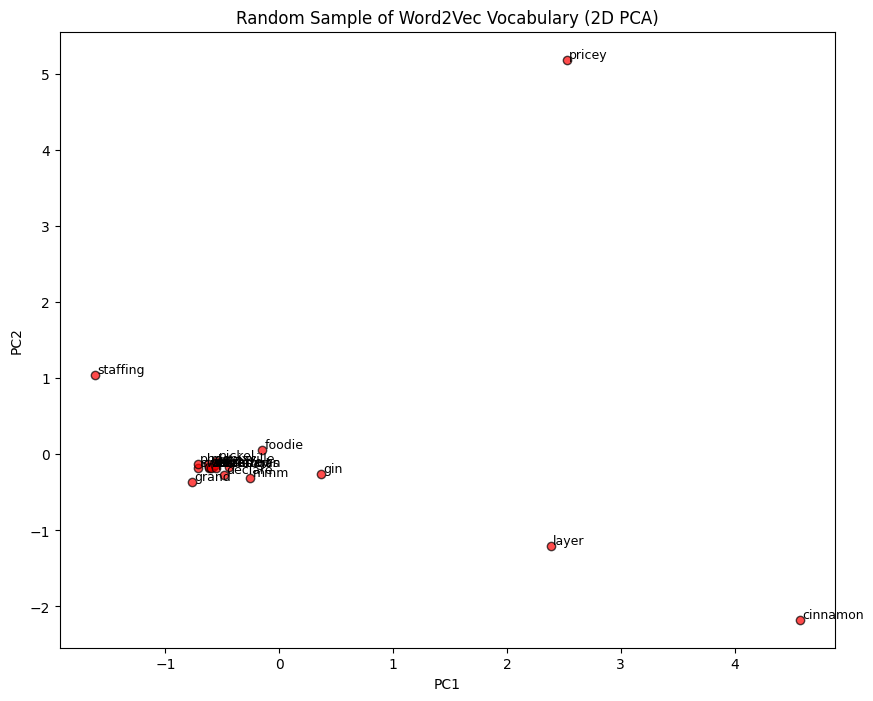

In [51]:
display_pca_scatterplot(model, sample=20)

#### ii. Pre-trained embeddings models
We'll also evaluate a couple of pretrained embeddings models.

#### a. Gensim pretrained models

In [52]:
# Gensim Glove pretrained models
[model for model in api.info()['models'].keys() if 'glove' in model]

['glove-wiki-gigaword-50',
 'glove-wiki-gigaword-100',
 'glove-wiki-gigaword-200',
 'glove-wiki-gigaword-300',
 'glove-twitter-25',
 'glove-twitter-50',
 'glove-twitter-100',
 'glove-twitter-200']

'glove-wiki-gigaword-200' pretrained model

In [53]:
glove_wiki = api.load('glove-wiki-gigaword-200')

In [54]:
glove_wiki.most_similar('saw')

[('came', 0.7834239602088928),
 ('seeing', 0.7421119809150696),
 ('seen', 0.7344871163368225),
 ('coming', 0.7182721495628357),
 ('when', 0.7094781398773193),
 ('went', 0.6966612339019775),
 ('took', 0.6953846216201782),
 ('back', 0.677486777305603),
 ('did', 0.673191249370575),
 ('brought', 0.67198646068573)]

'glove-twitter-200' pretrained model

In [55]:
glove_twitter = api.load('glove-twitter-200')

In [56]:
glove_twitter.most_similar('saw')

[('thought', 0.7656410336494446),
 ('seen', 0.7622860074043274),
 ('said', 0.7154862880706787),
 ('looked', 0.7126939296722412),
 ('knew', 0.7120527029037476),
 ('did', 0.706375002861023),
 ('watched', 0.7059610486030579),
 ('seeing', 0.6991493701934814),
 ('see', 0.6918333768844604),
 ('remember', 0.689777135848999)]

In [57]:
all_lemmas = [lemma for tokens in reviews_df.lemma_tokens for lemma in tokens]
unique_lemmas = list(set(all_lemmas))
lemmas_in_glove_wiki = [lemma for lemma in unique_lemmas if lemma in glove_wiki]
lemmas_in_glove_twitter = [lemma for lemma in unique_lemmas if lemma in glove_twitter]

print(len(unique_lemmas))
print(len(lemmas_in_glove_wiki))
print(len(lemmas_in_glove_twitter))

30041
24393
24993


### iii. Contextualized Transformer-based Embeddings

#### BERT

In [63]:
def get_review_embeddings_contextual(lemmas_string):
    """
    Encode one review (space-separated lemmas) into contextual embeddings per token.
    Returns dict {token: embedding_tensor}.
    """
    tokens = lemmas_string.split()
    embeddings = model.encode(tokens, convert_to_tensor=True)  # [num_tokens, 384]
    return dict(zip(tokens, embeddings))

# Apply to a single review
embeddings = get_review_embeddings_contextual(reviews_df['lemmas'][0])
print("Token embeddings shape:", embeddings[list(embeddings.keys())[0]].shape)

# Optional: average for a single review vector
def review_vector(tokens_embeddings):
    return torch.stack(list(tokens_embeddings.values())).mean(dim=0)

review_vec = review_vector(embeddings)
print("Review embedding shape:", review_vec.shape)

Token embeddings shape: torch.Size([384])
Review embedding shape: torch.Size([384])


In [66]:
reviews_df['lemma_embeddings'] = reviews_df['lemmas'].apply(get_review_embeddings_contextual)

In [68]:
reviews_df['review_vector'] = reviews_df['lemma_embeddings'].apply(review_vector)

In [69]:
reviews_df.head()

,review_id,business_id,stars,categories,date,text,lemmas,num_lemmas,month,review_length,avg_word_length,lemma_tokens,lemma_embeddings,review_vector
0,mG1FavLfA5j2L83sCZ3rFg,drTZrkbpSoJgwKETlFbc3w,1.0,"Shopping, Musical Instrument Services, Musical...",2022-01-01 15:47:07,I bought a Fender 1966 Telecaster that the sal...,buy fender telecaster salesperson tell origina...,50,1,641,5.0,"[buy, fender, telecaster, salesperson, tell, o...","{'buy': [tensor(-0.3502), tensor(-0.3202), ten...","[tensor(-0.1198), tensor(-0.0008), tensor(0.11..."
1,WMpnr1XBJ5U38rfSdErhJQ,jyxHti29yWdYR00Itt1A2w,5.0,"Restaurants, Mediterranean",2022-01-02 03:49:01,This is our go to for take out when I visit my...,visit son restaurant desert home food authenti...,14,1,208,4.0,"[visit, son, restaurant, desert, home, food, a...","{'visit': [tensor(0.2472), tensor(-0.1876), te...","[tensor(-0.0457), tensor(-0.0798), tensor(0.29..."
2,99EMi0lRhdmylbG0soaf9w,Jo4ei-c-5H53IxZxAVf1jQ,5.0,"Hair Salons, Men's Hair Salons, Barbers, Beaut...",2022-01-03 03:17:03,Danielle did a great job! She listened and cu...,danielle great job listen cut hair way request...,24,1,278,4.0,"[danielle, great, job, listen, cut, hair, way,...","{'danielle': [tensor(0.2697), tensor(-0.6797),...","[tensor(-0.1339), tensor(-0.2695), tensor(0.25..."
3,Qs4z8e7hCoU9EzRKD9rGPQ,YT5CjacTllBtvMaMJS3IbA,1.0,"Hotels & Travel, Hotels, Venues & Event Spaces...",2022-01-05 15:55:59,We saw a lot of roaches in the bathroom when w...,see lot roach bathroom wake bed large dark sta...,38,1,514,4.0,"[see, lot, roach, bathroom, wake, bed, large, ...","{'see': [tensor(0.1202), tensor(-0.0037), tens...","[tensor(0.0055), tensor(0.0707), tensor(0.2249..."
4,SXZ2Nw9UGAgPlXJsju9fFA,9MHe5jAym2d8VhT_NbCRyw,2.0,"Restaurants, Chinese, Thai",2022-01-06 03:59:21,We Ordered pork fried rice and beef chow mei ...,order pork fry rice beef chow mei fun teriyaki...,16,1,148,5.0,"[order, pork, fry, rice, beef, chow, mei, fun,...","{'order': [tensor(-0.5591), tensor(-0.3076), t...","[tensor(-0.0639), tensor(-0.0194), tensor(0.13..."


In [71]:
from sentence_transformers import util

pd.set_option('display.max_colwidth', None)

# Compute pairwise cosine similarity
cosine_sim = util.cos_sim(
    torch.stack(reviews_df['review_vector'].tolist()),
    torch.stack(reviews_df['review_vector'].tolist())
)

# Example: Find reviews most similar to review[0]
similarities = cosine_sim[0]
top_idx = torch.topk(similarities, 5).indices
print("Most similar reviews to review 0:")
print(reviews_df.iloc[top_idx]['text'])

Most similar reviews to review 0:
0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     

In [72]:
from collections import defaultdict

# Gather all occurrences of each word across all reviews
word_contexts = defaultdict(list)

for emb_dict in reviews_df['lemma_embeddings']:
    for word, vec in emb_dict.items():
        word_contexts[word].append(vec.cpu())  # keep as tensor


In [73]:
from sentence_transformers import util
import torch
import numpy as np

def contextual_variation(vectors):
    """Compute average cosine distance between all pairs of a word's embeddings."""
    if len(vectors) < 2:
        return 0.0
    sims = []
    for i in range(len(vectors)):
        for j in range(i+1, len(vectors)):
            sims.append(util.cos_sim(vectors[i], vectors[j]).item())
    return 1 - np.mean(sims)  # 1 - avg(similarity) = contextual variance


In [75]:
from sentence_transformers import util
import torch

# --- 1️⃣ Helper: fast contextual variation ---
def contextual_variation_fast(vectors):
    """
    Compute average pairwise cosine distance using vectorized ops.
    """
    if len(vectors) < 2:
        return 0.0
    X = torch.stack(vectors)
    sims = util.cos_sim(X, X)
    mask = ~torch.eye(len(X), dtype=bool)
    mean_sim = sims[mask].mean().item()
    return 1 - mean_sim  # higher = more varied meaning

# --- 2️⃣ Select 3 sample words that appear in multiple contexts ---
sample_words = [w for w, vecs in word_contexts.items() if len(vecs) >= 5][:3]

print(f"Analyzing {len(sample_words)} words:", sample_words)

# --- 3️⃣ Compute contextual variation only for those words ---
word_variation = {
    word: contextual_variation_fast(vecs)
    for word, vecs in {w: word_contexts[w] for w in sample_words}.items()
}

# --- 4️⃣ Display results ---
for word, score in word_variation.items():
    print(f"{word:15s} → contextual variation: {score:.3f}")


Analyzing 3 words: ['buy', 'fender', 'salesperson']
buy             → contextual variation: 0.000
fender          → contextual variation: 0.000
salesperson     → contextual variation: 0.000


### DistilBERT

In [76]:
from transformers import AutoTokenizer, AutoModel
import torch

# Load DistilBERT (lightweight, contextual model)
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
model = AutoModel.from_pretrained("distilbert-base-uncased")

# Ensure it runs on CPU
device = torch.device("cpu")
model.to(device)
model.eval()

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

DistilBertModel(
  (embeddings): Embeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer): Transformer(
    (layer): ModuleList(
      (0-5): 6 x TransformerBlock(
        (attention): DistilBertSdpaAttention(
          (dropout): Dropout(p=0.1, inplace=False)
          (q_lin): Linear(in_features=768, out_features=768, bias=True)
          (k_lin): Linear(in_features=768, out_features=768, bias=True)
          (v_lin): Linear(in_features=768, out_features=768, bias=True)
          (out_lin): Linear(in_features=768, out_features=768, bias=True)
        )
        (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (ffn): FFN(
          (dropout): Dropout(p=0.1, inplace=False)
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): L

In [77]:
def get_contextual_word_embedding(sentence, target_word):
    """
    Get the contextual embedding of a specific word within a sentence.
    Returns the mean embedding of all sub-tokens that match the target word.
    """
    inputs = tokenizer(sentence, return_tensors="pt", truncation=True, max_length=512)
    with torch.no_grad():
        outputs = model(**inputs)
    token_embeddings = outputs.last_hidden_state[0]  # [seq_len, 768]
    tokens = tokenizer.convert_ids_to_tokens(inputs["input_ids"][0])

    # Collect embeddings for tokens matching the word
    word_embs = [token_embeddings[i] for i, tok in enumerate(tokens) if target_word in tok]
    
    if len(word_embs) == 0:
        return None
    
    return torch.stack(word_embs).mean(dim=0)  # Average sub-token vectors

In [84]:
target_words = ["buy", "fender", "salesperson"]
word_contexts = {w: [] for w in target_words}

for text in reviews_df["lemmas"].head(50):  # test on 50 reviews for speed
    for word in target_words:
        emb = get_contextual_word_embedding(text, word)
        if emb is not None:
            word_contexts[word].append(emb)


AttributeError: 'DistilBertModel' object has no attribute 'encode'

In [79]:
from torch.nn.functional import cosine_similarity

def contextual_variation(embeddings):
    if len(embeddings) < 2:
        return 0.0
    mean_vec = torch.stack(embeddings).mean(dim=0)
    sims = [cosine_similarity(e.unsqueeze(0), mean_vec.unsqueeze(0)).item() for e in embeddings]
    return 1 - sum(sims)/len(sims)  # Higher = more varied meaning


In [80]:
for word, vecs in word_contexts.items():
    if len(vecs) >= 3:
        var = contextual_variation(vecs)
        print(f"{word:15s} → contextual variation: {var:.3f} ({len(vecs)} samples)")


buy             → contextual variation: 0.103 (4 samples)


In [82]:
target_word = "buy"

buy_reviews = reviews_df[reviews_df["lemmas"].str.contains(rf"\b{target_word}\b", case=False, regex=True)]

for i, review in enumerate(buy_reviews["lemmas"].tolist()):
    print(f"\n[{i}] {review}")



[0] service: 3
food quality: 5
drink quality: 5
order time: 5
aesthetics: 5
noise level: 5
menu selection: 3

overall experience: 4.4

After visiting New Orleans for Christmas we made this one our must visits after reading all the wine reviews in the town. They have a very large outdoor dining/drinking area with live music. 

If you've never been then it's quite simple. You walk into a, what seems like, a small liquor store. It technically is but you buy the bottle, and take it out back to drink, and listen to live music. They have a very extensive selection of wine. I would also recommend ordering a cheese board. We didn't, and we regretted it after seeing everyone else order it. 

I gave this place a 3 in service. The employees were nice but it's a very limited interaction. It's basically self serve. An employee at the register when you buy the wine, and after that you never see anyone. You go out back. You Order your food from your phone. The cook brings it out, and then you never 

In [83]:
import torch
from sentence_transformers import util

buy_vecs = word_contexts["buy"]
for i in range(len(buy_vecs) - 1):
    sim = util.cos_sim(buy_vecs[i], buy_vecs[i + 1]).item()
    print(f"Context {i} vs {i+1}: cosine similarity = {sim:.3f}")


Context 0 vs 1: cosine similarity = 0.750
Context 1 vs 2: cosine similarity = 0.727
Context 2 vs 3: cosine similarity = 0.713


In [85]:
word_contexts = {}

for idx, text in enumerate(reviews_df["lemmas"]):
    tokens = text.split()
    embeddings = model.encode(tokens, convert_to_tensor=True)
    for token, emb in zip(tokens, embeddings):
        token = token.lower()
        if token not in word_contexts:
            word_contexts[token] = []
        # Store both the embedding and the review index
        word_contexts[token].append((idx, emb))


AttributeError: 'DistilBertModel' object has no attribute 'encode'

#### ii. Visualize glove word embeddings
We can visualize similarity in words and observe how Glove model behaves 

In [ ]:
# Visualizing gensim pre-trained glove embeddings
# Reduce dimensions with PCA
# From datacamp
pca = PCA(n_components=2, random_state=42)

glove_word_vectors = glove_model[lemmas_in_glove]
glove_word_vectors_2d = pca.fit_transform(glove_word_vectors)

n = 30
glove_word_vectors = glove_word_vectors[:n]
lemmas_in_glove = lemmas_in_glove[:n]
glove_word_vectors_2d = glove_word_vectors_2d[:n]

plt.scatter(glove_word_vectors_2d[:, 0], glove_word_vectors_2d[:, 1], alpha=0.2)
for lemma_in_glove, (x, y) in zip(lemmas_in_glove, glove_word_vectors_2d):
    plt.annotate(lemma_in_glove, (x, y), fontsize=9)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("Gensim Pre-trained Glove Embeddings (2D PCA)")
plt.show()

In [ ]:
def get_review_glove_embedding(lemmas, model=glove_model):
    vectors = [glove_model[word] for word in lemmas if word in glove_model]
    if not vectors:
        return np.zeros(model.vector_size)
    return np.mean(vectors, axis=0)

In [ ]:
tqdm.pandas(desc="Vectorizing review lemmas using Glove pre-trained model", ncols=100)
reviews_pandas_df['glove_embedding'] = reviews_pandas_df['lemma_tokens'].progress_apply(get_review_glove_embedding)

In [ ]:
reviews_pandas_df[['lemmas', 'word_2_vec_embedding', 'glove_embedding']]

In [ ]:
X1 = np.vstack(reviews_pandas_df['word_2_vec_embedding'].values)
print(X1.shape)

X2 = np.vstack(reviews_pandas_df['glove_embedding'].values)
print(X2.shape)



# More complex embeddings: transformers, topic modeling google transformer embeddings
# Different Glove embeddings
# OPenAI, Gemini and HuggingFace

In [ ]:
new_pca = PCA(n_components=2, random_state=42)
w2v_2d = new_pca.fit_transform(X1)
glove_2d = new_pca.fit_transform(X2)

n = 60

# Word2Vec review embeddings plot
plt.figure(figsize=(14,6))
plt.subplot(1, 2, 1)
plt.scatter(w2v_2d[:n, 0], w2v_2d[:n, 1], alpha=0.5)
for i in range(n):
    plt.annotate(str(i), (w2v_2d[i, 0], w2v_2d[i, 1]))
plt.title("Word2Vec Review Embeddings (2D PCA)")

# Glove review embeddings plot
plt.figure(figsize=(14,6))
plt.subplot(1, 2, 2)
plt.scatter(glove_2d[:n, 0], glove_2d[:n, 1], alpha=0.5)
for i in range(n):
    plt.annotate(str(i), (glove_2d[i, 0], glove_2d[i, 1]))
plt.title("Glove Review Embeddings (2D PCA)")

In [ ]:
labels_w2v = kmeans.fit_predict(w2v_2d)

# Word2Vec review embeddings plot
plt.figure(figsize=(14,6))
sns.scatterplot(x=w2v_2d[:, 0], y=w2v_2d[:, 1], alpha=0.5, hue=labels_w2v, palette='tab10')
plt.title("Review Word2Vec Embedding Clusters (2D PCA)")
plt.show()

labels_glove = kmeans.fit_predict(glove_2d)

# Word2Vec review embeddings plot
plt.figure(figsize=(14,6))
sns.scatterplot(x=glove_2d[:, 0], y=glove_2d[:, 1], alpha=0.5, hue=labels_glove, palette='tab10')
plt.title("Review Glove Embedding Clusters (2D PCA)")
plt.show()

In [ ]:
# Set the option to display full column width
pd.set_option('display.max_colwidth', None)

reviews_pandas_df.iloc[[9,18], :][['text', 'lemma_tokens']]

In [ ]:
i, j = 32, 54
cosine_similarity([X1[i]], [X1[j]])

In [ ]:
cosine_similarity([X2[i]], [X2[j]])

In [ ]:
reviews_pandas_df.iloc[[32, 54], :][['text', 'lemma_tokens']]

In [ ]:
n_clusters = 6  # try a few values
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
clusters = kmeans.fit_predict(X2)

reviews_pandas_df["glove_cluster"] = clusters

In [ ]:
reviews_pandas_df[['text', 'glove_cluster']]

In [ ]:
k = 6  # number of clusters
for cluster_id in range(k):
    print(f"\n=== Cluster {cluster_id} ===")
    idxs = np.where(labels_w2v == cluster_id)[0]  # or labels_glove
    for i in idxs[:5]:  # first 5 reviews in this cluster
        print(f"** {reviews_pandas_df['text'].iloc[i]}")

In [ ]:
# Print a few reviews from each cluster
for cluster in sorted(reviews_pandas_df["cluster"].unique()):
    print(f"\n------Cluster {cluster}------\n")
    cluster_revs = reviews_pandas_df[reviews_pandas_df.cluster == cluster]['text'].head(5).values
    for rev in cluster_revs:
        print(f"**{rev}")